## Install Dependencies

In [106]:
#pip install numpy pandas matplotlib seaborn xgboost==2.0.3 scikit-learn

## Preprocess Dataset

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

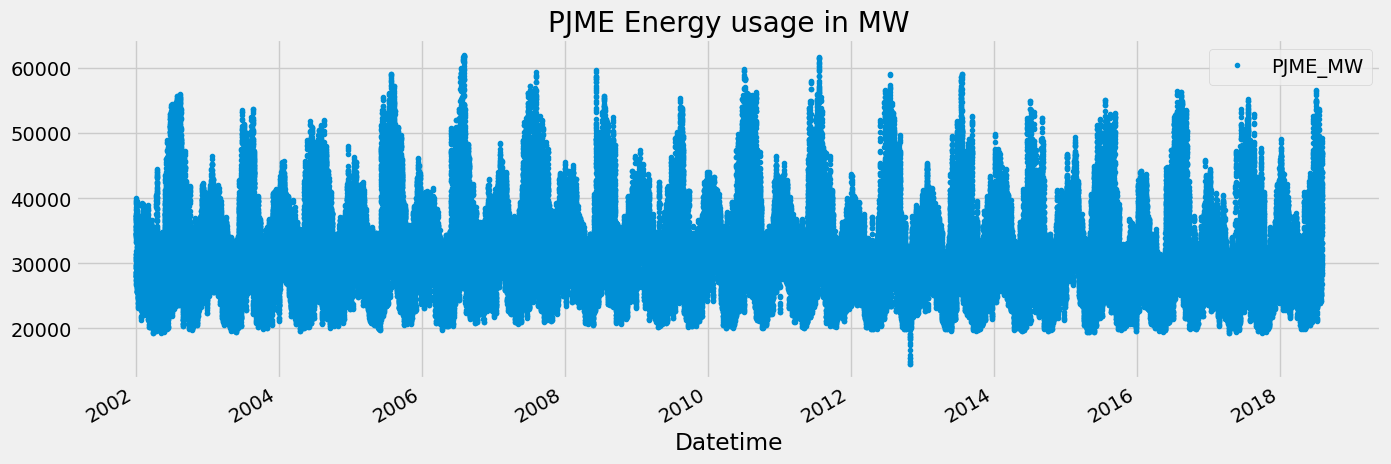

In [108]:
df = pd.read_csv('hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.plot(style='.', figsize=(15, 5), color=color_pal[0], title='PJME Energy usage in MW')
plt.show()

## Train/Test Split

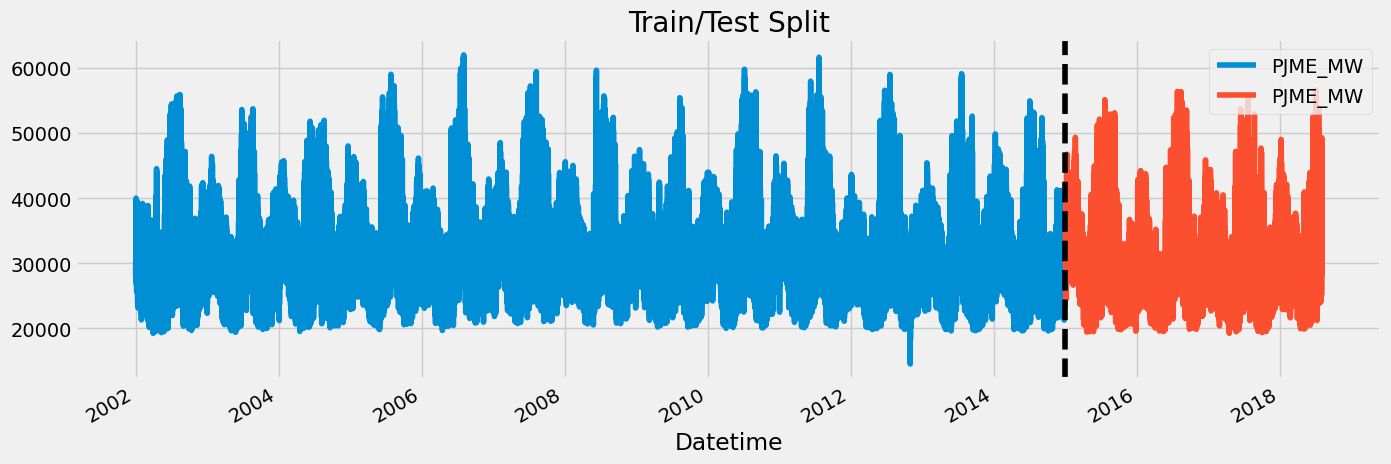

In [109]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
plt.show()

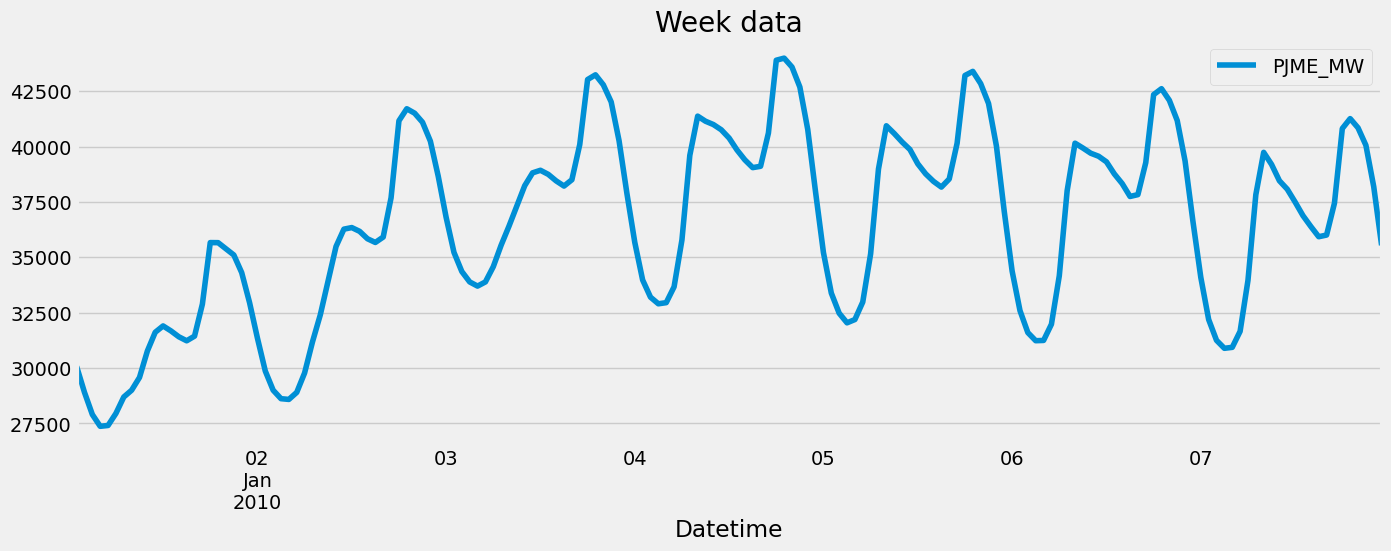

In [110]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')]\
    .plot(figsize=(15, 5), title='Week data')
plt.show()

## Feature Creation

In [111]:
def create_features(dataFrame):
    '''
    Create Features
    '''

    df = dataFrame.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    return df

df = create_features(df)

## Visualize Features / Target relationship

/var/folders/xs/v37l0rgs2gv8lhzn__8l6kvr0000gn/T/ipykernel_7790/608010752.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hour', y='PJME_MW', palette='Reds', legend=False)


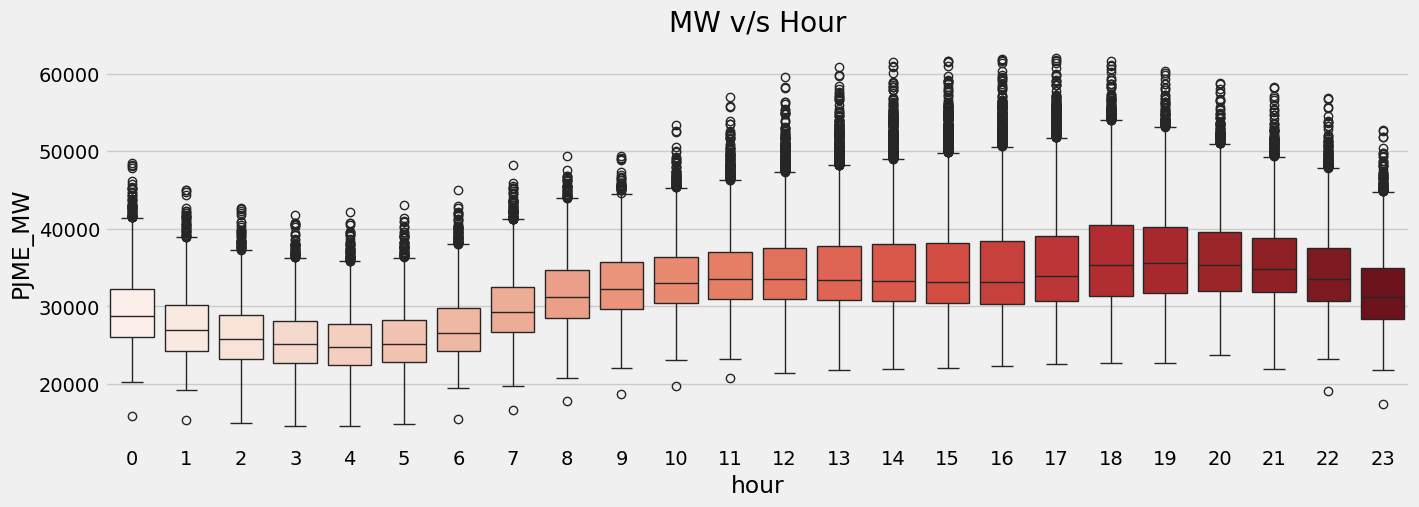

In [112]:
fig,ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='hour', y='PJME_MW', palette='Reds', legend=False)
ax.set_title('MW v/s Hour')
plt.show()

/var/folders/xs/v37l0rgs2gv8lhzn__8l6kvr0000gn/T/ipykernel_7790/2216898825.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues', legend=False)


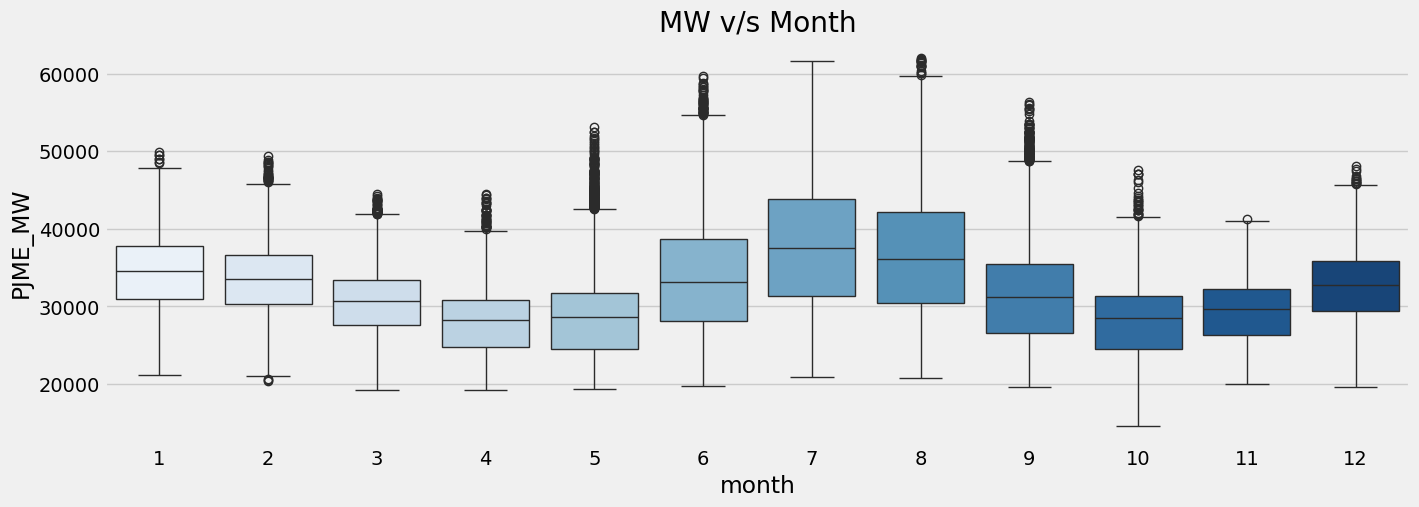

In [113]:
fig,ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues', legend=False)
ax.set_title('MW v/s Month')
plt.show()

## Train the Model

In [114]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [115]:
reg = xgb.XGBRegressor(n_estimators=1000, 
                       early_stopping_rounds=50, 
                       learning_rate=0.01)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance

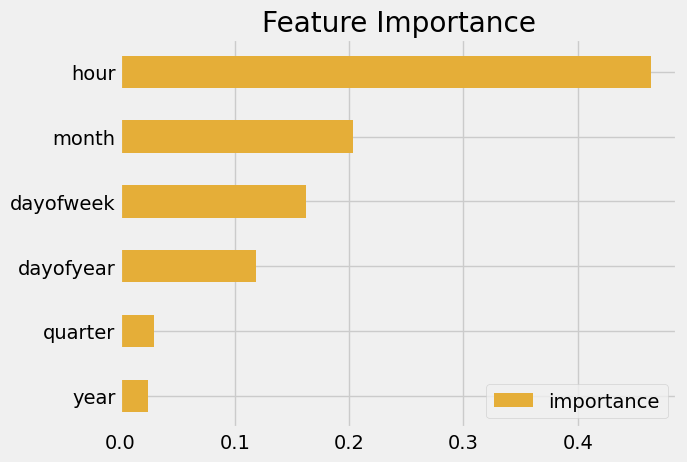

In [116]:
feature_importance = pd.DataFrame(data=reg.feature_importances_,
                                index=reg.feature_names_in_,
                                columns=['importance'])

feature_importance.sort_values('importance').plot(kind='barh', color=color_pal[2], title='Feature Importance')
plt.show()

# Test the Model

In [117]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

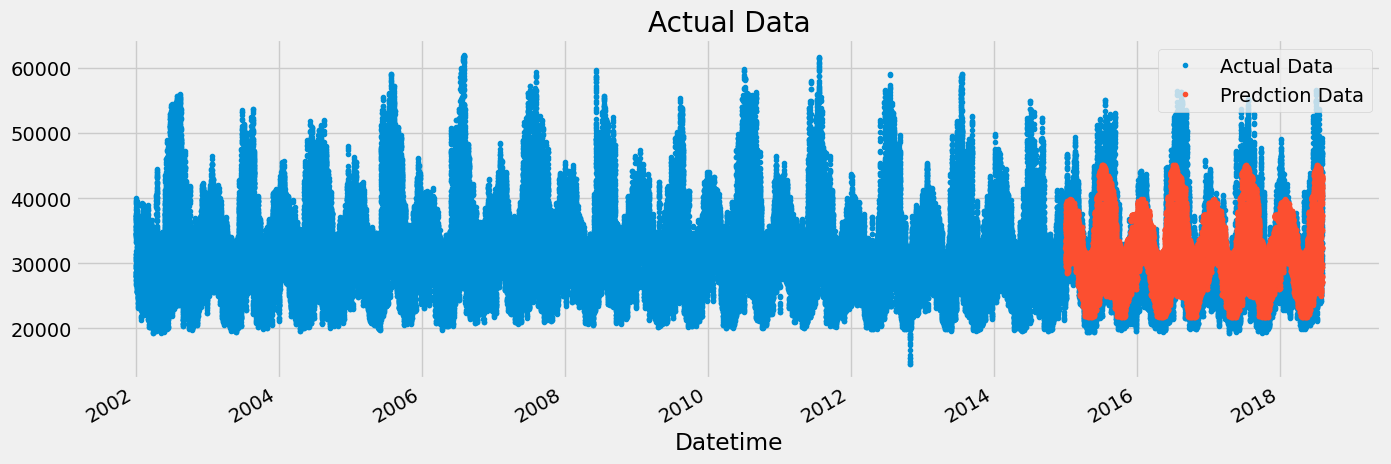

In [118]:
fig, ax = plt.subplots(figsize=(15, 5))
df[['PJME_MW']].plot(ax=ax, style='.')
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predction Data'])
ax.set_title('Actual Data')
plt.show()

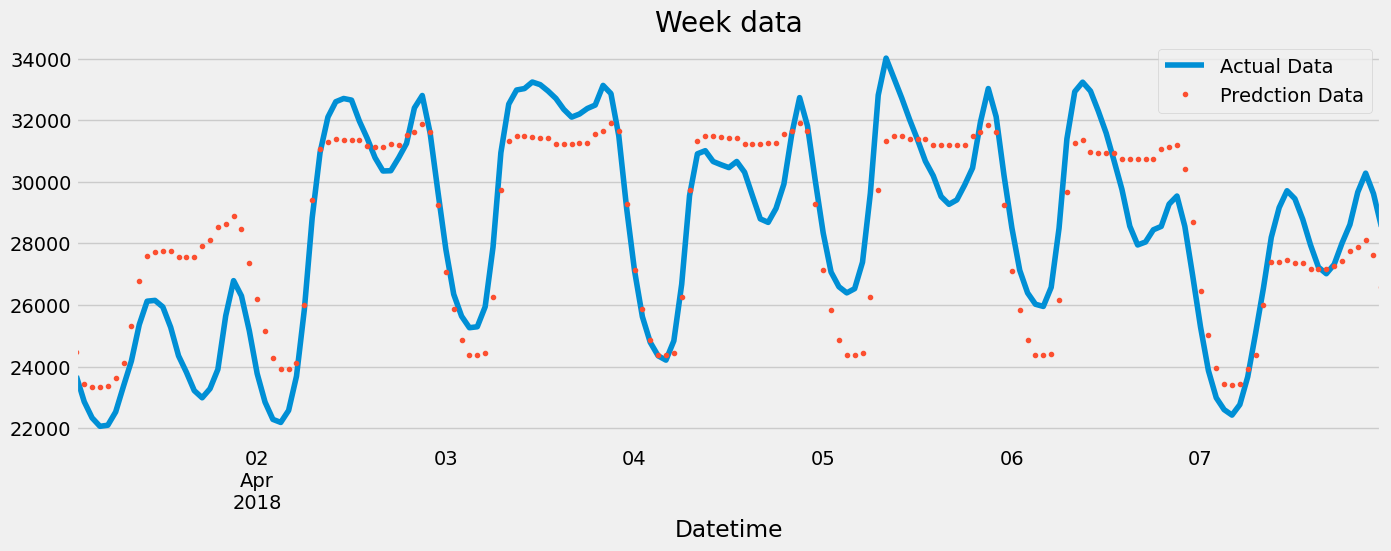

In [119]:
fig, ax = plt.subplots(figsize=(15, 5))
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'].plot(ax=ax, figsize=(15, 5))
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(ax=ax, style='.', figsize=(15, 5))
ax.set_title('Week data')
plt.legend(['Actual Data', 'Predction Data'])
plt.show()

In [120]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test Set: {score:0.2f}')

RMSE Score on Test Set: 3741.03


## Calculate Error

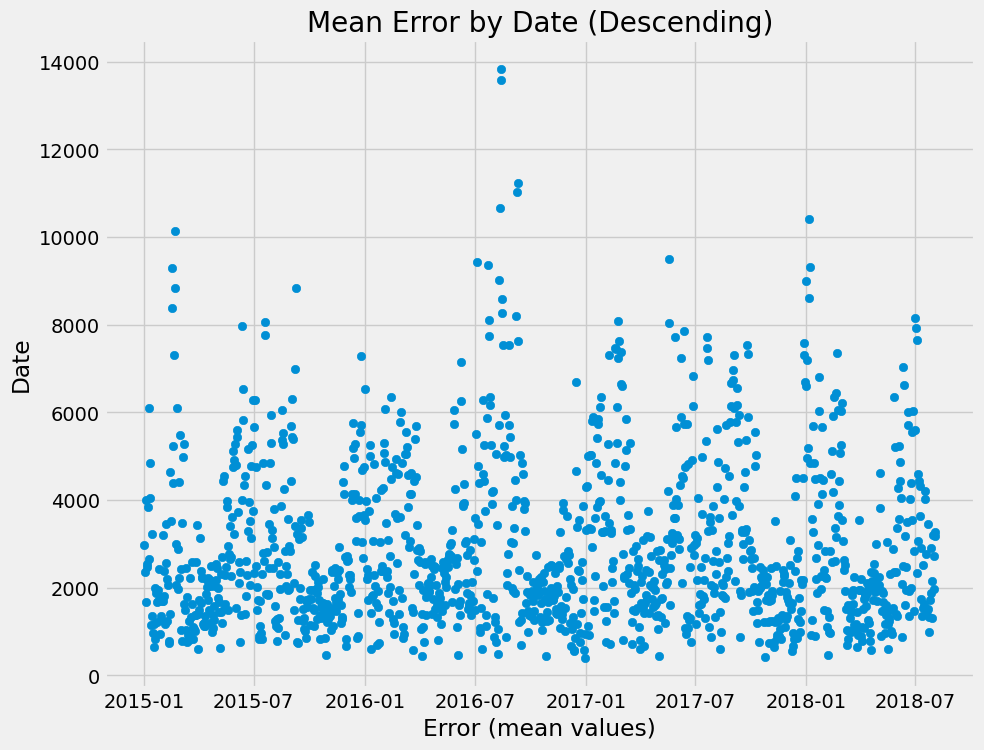

In [171]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
error_data = test.groupby('date')['error'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(error_data.index, error_data.values)  # x is error, y is date
# ax.set(xlim=(-2, 2), ylim=(-3, 3))
plt.xlabel('Error (mean values)')
plt.ylabel('Date')
plt.title('Mean Error by Date (Descending)')
# plt.gca().invert_yaxis()  # Optional: Reverse the y-axis if you want the largest error at the top
plt.show()

In [122]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
Name: error, dtype: float64